In [1]:
import numpy as np
import hera_qm.ant_metrics as ant_metrics
from hera_qm.data import DATA_PATH
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Setup

In [2]:
verbose = True
data_files = DATA_PATH + '/zen.2457698.40355.full_pol_test.uvh5'
extension = '.ant_metrics.hdf5'
metrics_outfile = data_files.replace('.uvh5', extension)

# Main script for computing and saving metrics

In [3]:
ant_metrics.ant_metrics_run(data_files, crossCut=3.0, deadCut=3.0, extension=extension, overwrite=True)

Selected polarization values are not evenly spaced. This will make it impossible to write this data out to some file types
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 33.733078062221985 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


On iteration 0 we flag (81, 'Jxx') with modified z of 15.409292791174419.
On iteration 0 we flag (81, 'Jyy') with modified z of 15.409292791174419.
On iteration 1 we flag (112, 'Jxx') with modified z of 3.3344479568589755.
On iteration 2 we flag (80, 'Jxx') with modified z of 3.3685546120496332.
On iteration 2 we flag (80, 'Jyy') with modified z of 3.3685546120496332.
Now saving results to /Users/jsdillon/anaconda3/envs/python3/lib/python3.8/site-packages/hera_qm/data/zen.2457698.40355.full_pol_test.ant_metrics.hdf5


# Plotting

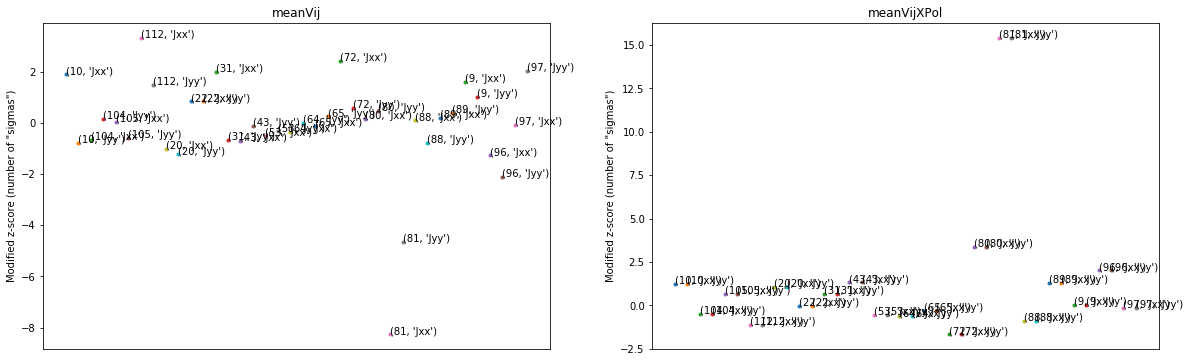

In [4]:
metrics_results = ant_metrics.load_antenna_metrics(metrics_outfile)

fig, axes = plt.subplots(1,2, figsize=(20,6))
for ax, (key, metrics) in zip(axes, metrics_results['final_mod_z_scores'].items()):
    for x, ant in enumerate(metrics):
        ax.plot(x, metrics[ant], '.')
        ax.annotate(str(ant), xy=(x, metrics[ant]))
    ax.set_ylabel('Modified z-score (number of "sigmas")')
    ax.set_title(key)
    ax.set_xticks([])

In [5]:
# clean up
os.remove(metrics_outfile)